<a href="https://colab.research.google.com/github/yehaa2004/Bharathintern_Task-1/blob/main/use_case_10_FaceDetection_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pins-face-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F543939%2F992580%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T074030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d9d583bf11da8ed6474fd57d6666ad1fc01fb7e9c4b572ff1f9c8786e7131470f40ccc74f0de0dc0ebd5933f8aa1d9032499e85e73dbd818dfd55b9e9ff114ab7906ccb0834d4ffce3adb0c7059389d9408119e9e8e39395ddd474cef85536b6dc2024c39fd69c61c9078815bcc19a05f79bdc35752090c3588a7553e569dd463d7e54b4776f1c2ba3253bb4f65601753b5891dd3dcbd94aa433d9af7c03aa4a2b2b4a74d847ca98e089bb35573449cc469861930ac584587d4d37b676f3f04519e53727591af8ad5151326edec2975e895e8af600f3257086f7b6947fabf204ee2b9e27bfed6689b9d6861bd387d85ad7f4ffbb5109c5064da30a52fecdaa4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 389784397 bytes downloaded
Downloaded and uncompressed: pins-face-recognition
Data source import complete.


## INTRODUCTION

Face detection and face recognition are two related but distinct tasks in the field of computer vision and image processing.

Face Detection:

Objective: The primary goal of face detection is to locate and identify faces within an image or a video stream.

Process:

Face detection algorithms analyze the input image to identify regions or bounding boxes containing faces. These algorithms don't necessarily recognize whose face it is; they only detect the presence and location of faces.

Techniques:

Various techniques are used for face detection, including traditional methods like Haar cascades and more advanced methods using deep learning, such as Single Shot MultiBox Detector (SSD) or Faster R-CNN.


Face Recognition:

Objective:

Face recognition, on the other hand, involves identifying and verifying a person's identity based on their facial features. It associates detected faces with specific individuals whose identities are known.

Process:

Face recognition systems capture facial features, create a unique representation or "embedding" of each face, and then compare these embeddings to a database of known faces for identification or verification purposes.

Techniques:

Deep learning approaches, especially convolutional neural networks (CNNs), have proven effective for face recognition. Embeddings from face recognition models, like those trained on FaceNet or VGGFace, enable accurate comparisons between faces.

In summary, face detection is the initial step that locates faces within an image, while face recognition goes a step further by identifying and verifying the individuals associated with those faces. Both tasks have numerous applications, including security systems, surveillance, user authentication, and human-computer interaction. Advances in deep learning have significantly improved the accuracy and robustness of face detection and recognition systems.

We are given datasets of images that are already labeled and our goal will be to set up a face recognition process by detecting faces first and extracting its features. We will be implementing multiple approaches. Recognition by using the distance between embeddings and recognition by training the embeddings and evaluating unseen embeddings for classification/recognition. Its importatnt to note that we will a lot of images with high quality for the models to work accurately.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from matplotlib import pyplot as plt


In [3]:

# Specify the path to the main directory
main_directory = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

# Initialize counts
folder_count = 0
total_file_count = 0

# Iterate through the main directory
for root, dirs, files in os.walk(main_directory):
    # Count folders
    folder_count += len(dirs)

    # Count files in each folder
    folder_file_count = len(files)
    total_file_count += folder_file_count

    # Print the folder name and the number of files in that folder
    print(f"Folder: {os.path.basename(root)}, Files: {folder_file_count}")

# Print the overall results
print(f"\nNumber of folders: {folder_count}")
print(f"Total number of files: {total_file_count}")


Folder: 105_classes_pins_dataset, Files: 0
Folder: pins_Jimmy Fallon, Files: 113
Folder: pins_Robert De Niro, Files: 156
Folder: pins_Natalie Portman, Files: 166
Folder: pins_Emma Watson, Files: 211
Folder: pins_Jennifer Lawrence, Files: 180
Folder: pins_Morgan Freeman, Files: 105
Folder: pins_Neil Patrick Harris, Files: 116
Folder: pins_Morena Baccarin, Files: 175
Folder: pins_Richard Harmon, Files: 148
Folder: pins_Brenton Thwaites, Files: 209
Folder: pins_Lili Reinhart, Files: 150
Folder: pins_Anne Hathaway, Files: 203
Folder: pins_elizabeth olsen, Files: 221
Folder: pins_kiernen shipka, Files: 203
Folder: pins_Taylor Swift, Files: 131
Folder: pins_Bobby Morley, Files: 138
Folder: pins_Elizabeth Lail, Files: 158
Folder: pins_Millie Bobby Brown, Files: 191
Folder: pins_Danielle Panabaker, Files: 181
Folder: pins_Chris Evans, Files: 166
Folder: pins_Johnny Depp, Files: 182
Folder: pins_Shakira Isabel Mebarak, Files: 154
Folder: pins_Natalie Dormer, Files: 198
Folder: pins_Wentworth Mi

## DEMONSTRATING TECHNIQUES and EXPLAINING TERMINOLOGY

Below you will see demos of face detection, face embeddings and face landmarks.

Randomly pick few images and display - images are mostly close ups but to ensure more accurate face recognition, we will apply face detection before processing for face recogntion.

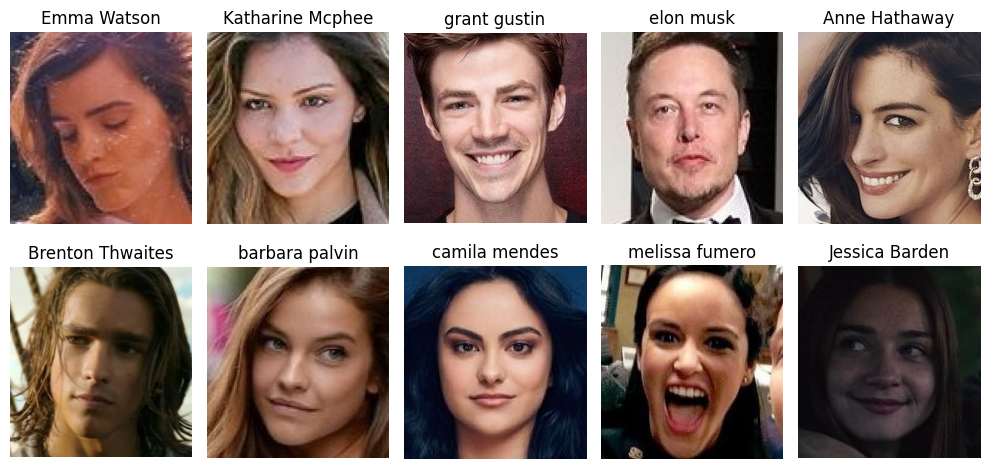

In [4]:

# Specify the path to the main directory
main_directory = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

# Get a list of all folders
all_folders = [folder for folder in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, folder))]

# Randomly pick 10 folders
selected_folders = random.sample(all_folders, 10)

# Create a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Iterate through selected folders and display one random image from each folder
for i, folder in enumerate(selected_folders):
    folder_path = os.path.join(main_directory, folder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    # Randomly pick one image
    selected_image = random.choice(all_images)

    # Get the full path to the selected image
    image_path = os.path.join(folder_path, selected_image)

    # Read and display the image
    img = mpimg.imread(image_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')

    # Extract label from folder name and drop the first 5 characters
    label = folder[5:]
    axes[i // 5, i % 5].set_title(label)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [5]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.9 MB/s eta 0:00:00


We randomly pick one image and apply face detection for demonstration purposes using MTCNN library. Face detection is a crucial pre-processing step before face recognition for several reasons:

Localization of Faces:

Identification of Regions of Interest (ROI): Face detection helps identify and locate the regions of an image or video frame that contain faces. This is essential for isolating the facial features from the rest of the scene.

Efficiency:

Reducing Computation: Face detection significantly reduces the computational load for subsequent face recognition tasks. By focusing on areas containing faces, the algorithm doesn't need to process the entire image, making the recognition process more efficient.
Accuracy:

Enhanced Accuracy: When a face recognition algorithm operates on pre-detected faces, it can achieve higher accuracy. This is because the algorithm can concentrate on analyzing facial features without being distracted by irrelevant background information.
Handling Multiple Faces:

Dealing with Multiple Faces: In scenarios where there are multiple individuals in an image or video frame, face detection helps identify and isolate each face, enabling the face recognition system to process one face at a time.

Improving Speed:

Real-time Applications: In real-time applications, such as video surveillance or live streaming, the speed of face detection allows for faster processing and identification of individuals. This is especially critical in time-sensitive applications, such as security and access control.

Noise Reduction:

Filtering Out Non-Facial Elements: Face detection helps filter out non-facial elements, such as objects or complex backgrounds, that might interfere with the face recognition process. This noise reduction contributes to the overall accuracy of the face recognition system.
Privacy Considerations:

Minimizing Privacy Concerns: By detecting faces first, privacy concerns can be addressed more effectively. Face detection can be used to ensure that facial recognition is applied only when necessary and within the appropriate context.

Resource Optimization:

Optimizing Resource Usage: Face detection allows for the allocation of resources only to areas containing faces, optimizing memory and processing power. This is particularly important in resource-constrained environments.

1/1 [==============================] - 0s 132ms/step


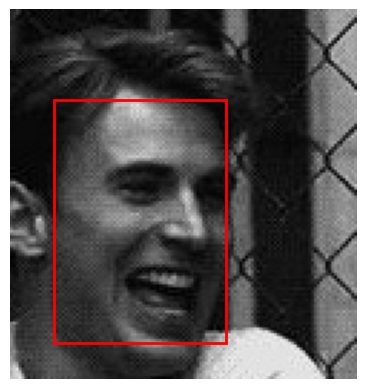

In [6]:
import matplotlib.patches as patches
from mtcnn import MTCNN

# Function to perform face detection and display the image with bounding boxes
def detect_and_display_faces(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to RGB for compatibility with MTCNN
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load the pre-trained MTCNN model
    detector = MTCNN()

    # Perform face detection
    faces = detector.detect_faces(img_rgb)

    # Display the original image
    fig, ax = plt.subplots()
    ax.imshow(img_rgb)

    # Add bounding boxes for each detected face
    for face in faces:
        x, y, w, h = face['box']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Specify the path to the main directory
main_directory = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

# Get a list of all folders
all_folders = [folder for folder in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, folder))]

# Randomly pick a folder
selected_folder = random.choice(all_folders)
folder_path = os.path.join(main_directory, selected_folder)

# Get a list of all images in the selected folder
all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Randomly pick an image from the folder
selected_image = random.choice(all_images)
image_path = os.path.join(folder_path, selected_image)

# Perform face detection using MTCNN and display the result
detect_and_display_faces(image_path)


In [7]:
import os
import shutil

# Set the directory path
directory_path = '/kaggle/working/'

# Remove all files and subdirectories in the directory
for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)
    if os.path.isfile(item_path) or os.path.islink(item_path):
        os.unlink(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("Contents of the working directory cleared.")


Contents of the working directory cleared.


We will be copying around 100 images from each folder to another folder to apply preprocessing steps and also do a train/test split.

In [8]:
import shutil

# Source directory
source_directory = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

# Destination directory
destination_directory = '/kaggle/working/'

# Create train and test directories if not exist
train_directory = os.path.join(destination_directory, 'train')
os.makedirs(train_directory, exist_ok=True)


# Get a list of all folders in the source directory
all_folders = [folder for folder in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, folder))]

# Iterate through each folder
for folder in all_folders:
    folder_path = os.path.join(source_directory, folder)

    # Get a list of all images in the folder
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    # Create a label for the folder (drop the first 5 characters)
    label = folder[5:]

    # Shuffle the images
    random.shuffle(all_images)

    # Move the first 85 images to the train directory
    for i in range(85):
        image_path = os.path.join(folder_path, all_images[i])
        destination_path = os.path.join(train_directory, label, all_images[i])
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(image_path, destination_path)


print("Data splitting completed.")


Data splitting completed.


MTCNN (Multi-task Cascaded Convolutional Networks) is a popular deep learning-based face detection algorithm. It's designed to detect faces and their facial landmarks in an image. MTCNN is widely used in computer vision applications and is known for its ability to efficiently and accurately locate faces in various settings.

The MTCNN algorithm consists of three stages:

Face Detection:

The first stage identifies candidate regions containing faces using a convolutional neural network (CNN). This stage produces a set of bounding boxes that may contain faces.
Bounding Box Refinement:

The second stage refines the bounding boxes obtained in the first stage. It involves further processing to improve the accuracy of the face location by adjusting the coordinates of the bounding boxes.
Facial Landmark Localization:

The third stage is responsible for identifying facial landmarks, such as the eyes, nose, and mouth, within the detected faces. This stage provides additional information about the facial structure.

Again for demonstration, we will randomly pick two images, apply face detection, define bounding box on the face and identify facial landmarks. You can also observe how the landmarks are plotted on the face with their coordinates shown on the picture frame below. Capturing landmarks are important especially for tasks like emotion detection where we need specific features extracted from each face to for training purposes.

1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 126ms/step


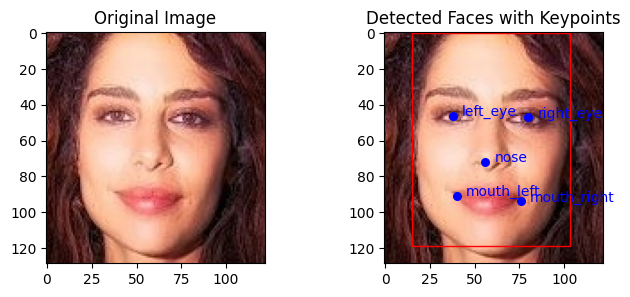

Metadata of detected faces in Nadia Hilker/Nadia Hilker110_8.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [15, 0, 88, 119]
   Keypoints: {'left_eye': (38, 46), 'right_eye': (80, 47), 'nose': (56, 72), 'mouth_left': (40, 91), 'mouth_right': (76, 94)}

1/1 [==============================] - 0s 25ms/step


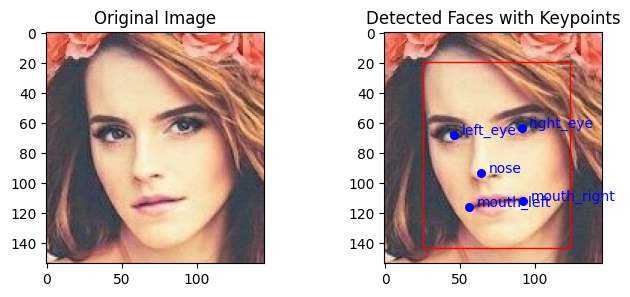

Metadata of detected faces in Emma Watson/Emma Watson91_2045.jpg:
Face 1:
   Confidence: 1.00
   Bounding Box: [25, 19, 98, 124]
   Keypoints: {'left_eye': (46, 68), 'right_eye': (91, 63), 'nose': (64, 93), 'mouth_left': (56, 116), 'mouth_right': (92, 112)}



In [9]:
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

# Directory paths
train_directory = '/kaggle/working/train'

# Get a list of all folders in the train directory
all_folders = [folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

# Randomly select two folders
selected_folders = random.sample(all_folders, 2)

# Initialize MTCNN detector
detector = MTCNN()

# Iterate through selected folders
for folder in selected_folders:
    folder_path = os.path.join(train_directory, folder)

    # Get a list of all images in the folder
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    # Randomly select one image
    selected_image = random.choice(all_images)
    image_path = os.path.join(folder_path, selected_image)

    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces = detector.detect_faces(image)

    # Display image with bounding boxes around detected faces
    plt.figure(figsize=(8, 3))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')

    # Display image with bounding boxes
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)

    for face in faces:
        x, y, width, height = face['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        plt.gca().add_patch(rect)

        # Display additional keypoints
        for key, value in face['keypoints'].items():
            plt.scatter(value[0], value[1], s=30, color='blue', marker='o')
            plt.text(value[0] + 5, value[1], key, color='blue')

    plt.title('Detected Faces with Keypoints')
    plt.show()

    # Display metadata of detected faces
    print(f"Metadata of detected faces in {folder}/{selected_image}:")
    for i, face in enumerate(faces):
        print(f"Face {i + 1}:")
        print(f"   Confidence: {face['confidence']:.2f}")
        print(f"   Bounding Box: {face['box']}")
        print(f"   Keypoints: {face['keypoints']}")
        print()


The extraction of face embeddings involves capturing and encoding facial features into a numerical representation, often in the form of a vector or embedding. These face embeddings serve as compact and distinctive representations of facial characteristics and can be used for tasks like face recognition, verification, and clustering. The process typically involves the following steps:

Face Detection:

Identify and locate faces within an image or video frame. Face detection algorithms, such as MTCNN or Haar cascades, are commonly used for this purpose.

Face Alignment:

Ensure that facial features are aligned consistently across different images. This step helps in reducing variations caused by head pose, tilt, and other factors. Facial landmarks, like the positions of the eyes, nose, and mouth, are often used for alignment.

Preprocessing:

Preprocess the detected faces to enhance the quality of the input for the embedding model. Common preprocessing steps include resizing, normalization, and sometimes data augmentation.

Feature Extraction using Deep Learning:

Employ a deep learning-based face recognition model, often a Convolutional Neural Network (CNN), to extract features from the preprocessed face images. Models such as FaceNet, VGGFace, or OpenFace are popular choices for this task.

Embedding Generation:

The output of the deep learning model is a high-dimensional feature vector (embedding) that represents the unique characteristics of the face. The embedding is a numerical representation in a vector space where similar faces have similar embeddings.

Normalization:

Normalize the embeddings to ensure that they are unit vectors. This can be important for certain distance metrics used in face recognition.

Below demonstrates the vectorization of the face features in a 2 dimensional array. We use MTCNN and a pretrained VGGface model to apply face detection and to extract embeddings.

In [10]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

  0%|          | 0.00/107M [00:00<?, ?B/s]

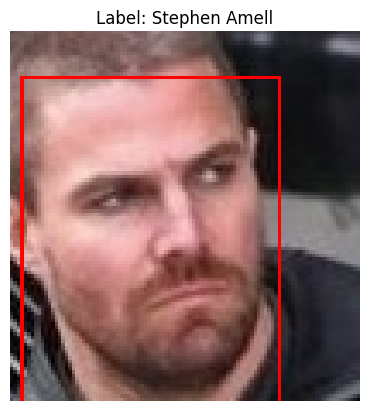

Embeddings for Detected Face 1: [ 4.95235473e-02 -1.60218179e-02  3.54804434e-02  1.05168372e-02
  6.39167130e-02 -6.01198971e-02 -1.43772811e-02 -6.98867301e-03
 -1.02684516e-02 -3.37283686e-02 -9.59302336e-02 -3.25419717e-02
 -9.00165215e-02 -1.38658518e-02  7.23808333e-02 -4.97181565e-02
 -9.65466630e-03 -6.51045842e-03  2.11242028e-02  3.88676897e-02
  2.11747028e-02  3.54608074e-02 -3.75536047e-02  3.06994747e-03
  1.16317701e-02  1.09291356e-02  1.11243851e-01 -9.33631603e-03
  3.95815633e-02 -9.61813331e-02 -1.29317734e-02  3.88783962e-02
  2.25276761e-02  1.81973651e-02  7.35123977e-02  1.62813310e-02
 -6.23681284e-02  3.82666104e-02 -3.25705856e-02  3.46464142e-02
 -7.24077970e-03  1.29597420e-02  2.90783471e-03 -1.21962070e-01
 -2.13133339e-02 -5.57945184e-02  1.81018487e-02 -7.46216346e-03
 -6.22074269e-02  3.49464379e-02  9.85703766e-02  6.74524009e-02
  5.16704731e-02  6.40325174e-02 -8.57987627e-03 -5.23829348e-02
  4.48755957e-02  7.09576607e-02  8.02454166e-03  2.987040

In [11]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image

# Function to process image, detect face, and calculate embeddings
def process_image(image_path, face_detector, face_embedder, label):
    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    boxes, probs = face_detector.detect(image_rgb)

    if boxes is not None:
        # Display label of the image using the folder it is picked up from
        plt.title(f"Label: {label}")

        # Display original image
        plt.imshow(Image.fromarray(image_rgb))

        # Draw a rectangle around each detected face on the original image
        for i, box in enumerate(boxes):
            x, y, w, h = box
            # Draw a rectangle around the detected face with thinner lines
            cv2.rectangle(image_rgb, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 1)

        # Display the image with the rectangles around detected faces
        plt.imshow(Image.fromarray(image_rgb))

        plt.axis('off')
        plt.show()

        # Apply transformations and normalization
        transformed_faces = [face_embedder(extract_face(image_rgb, box).unsqueeze(0)) for box in boxes]

        # Convert PyTorch tensor to NumPy array
        transformed_faces_np = [transformed_face.squeeze().detach().numpy() for transformed_face in transformed_faces]

        # Print the embeddings
        for i, embeddings in enumerate(transformed_faces_np):
            print(f"Embeddings for Detected Face {i + 1}:", embeddings)

# Directory paths
train_directory = '/kaggle/working/train/'

# Randomly pick a folder
selected_folder = random.choice(os.listdir(train_directory))
selected_folder_path = os.path.join(train_directory, selected_folder)

# Randomly pick one file from the selected folder
file = random.choice(os.listdir(selected_folder_path))
file_path = os.path.join(selected_folder_path, file)

# Initialize MTCNN for face detection with adjusted parameters
face_detector = MTCNN(margin=20, post_process=False, select_largest=False)

# Initialize InceptionResnetV1 for face embedding
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

# Process image, detect faces, calculate embeddings, and display results
process_image(file_path, face_detector, face_embedder, label=selected_folder)




In order to recognize a face from a database of images, we will be comparing the embeddings to a set of other embeddings and calculate the distance between embeddings. If our detection model is set up properly, the shortest distance between two embeddings will allow us to recognize and match with the correct label. Below demonstrates how this distance between two embedding for the same person and for two different people can vary.

Distance calced for different people - We use the Euclidean distance calculcation for this task.

Smaller Euclidean distances indicate more similar embeddings, while larger distances suggest dissimilarity.

In face recognition, the Euclidean distance is often used as a measure of similarity, and a threshold is set to determine if two faces are considered a match or not.

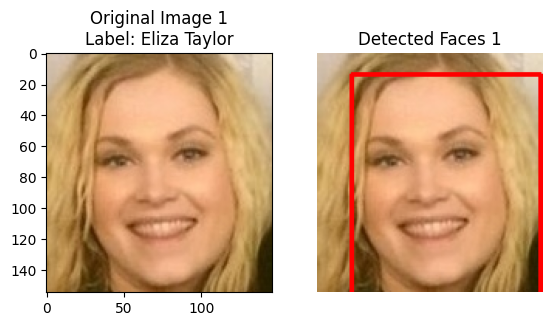

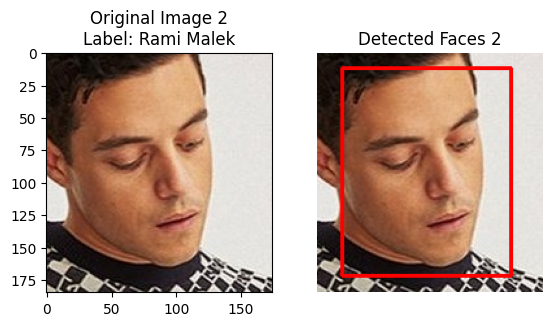

Distance between embeddings: 0.2441


In [12]:

from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances

# Function to process images, detect faces, and calculate embeddings
def process_images(folder_path1, file1, folder_path2, file2, face_detector, face_embedder):
    # Read the images
    image1_path = os.path.join(folder_path1, file1)
    image2_path = os.path.join(folder_path2, file2)

    image1 = cv2.imread(image1_path)
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image2 = cv2.imread(image2_path)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces1, _ = face_detector.detect(image1_rgb)
    faces2, _ = face_detector.detect(image2_rgb)

    # Get labels from folder names
    label1 = os.path.basename(folder_path1)
    label2 = os.path.basename(folder_path2)

    # Display original images with rectangles around detected faces
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Original Image 1\nLabel: {label1}")

    for i, face in enumerate(faces1):
        x, y, w, h = face
        # Draw a rectangle around the detected face
        cv2.rectangle(image1_rgb, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Detected Faces 1")
    plt.axis('off')

    plt.show()

    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Original Image 2\nLabel: {label2}")

    for i, face in enumerate(faces2):
        x, y, w, h = face
        # Draw a rectangle around the detected face
        cv2.rectangle(image2_rgb, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Detected Faces 2")
    plt.axis('off')

    plt.show()

    # Calculate embeddings for the first image
    embeddings1 = [face_embedder(extract_face(image1_rgb, face).unsqueeze(0)).squeeze().detach().numpy() for face in faces1]

    # Print the embeddings for the first image
    #for i, embeddings in enumerate(embeddings1):
     #   print(f"Embeddings for Detected Face {i + 1} in Image 1:", embeddings)

    # Calculate embeddings for the second image
    embeddings2 = [face_embedder(extract_face(image2_rgb, face).unsqueeze(0)).squeeze().detach().numpy() for face in faces2]

    # Print the embeddings for the second image
   # for i, embeddings in enumerate(embeddings2):
    #    print(f"Embeddings for Detected Face {i + 1} in Image 2:", embeddings)

    # Calculate distance between the two embeddings
    distance = euclidean_distances(embeddings1[0].reshape(1, -1), embeddings2[0].reshape(1, -1))[0][0]

    # Display the distance between the two embeddings
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_directory = '/kaggle/working/train/'

# Randomly pick two folders
selected_folders = random.sample(os.listdir(train_directory), 2)

# Randomly pick one file from each selected folder
file1 = random.choice(os.listdir(os.path.join(train_directory, selected_folders[0])))
file2 = random.choice(os.listdir(os.path.join(train_directory, selected_folders[1])))

# Initialize MTCNN for face detection
face_detector = MTCNN(keep_all=True)

# Initialize InceptionResnetV1 for face embedding
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

# Process images, detect faces, calculate embeddings, and display results
process_images(
    os.path.join(train_directory, selected_folders[0]),
    file1,
    os.path.join(train_directory, selected_folders[1]),
    file2,
    face_detector,
    face_embedder
)


Distance between embeddings calced for the same person.

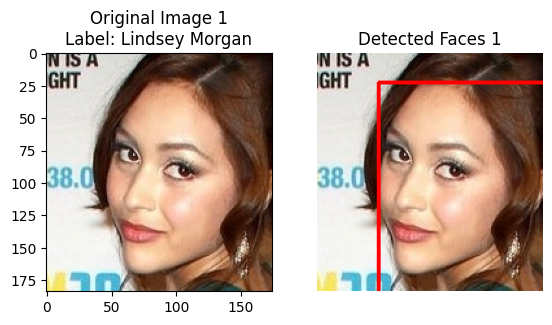

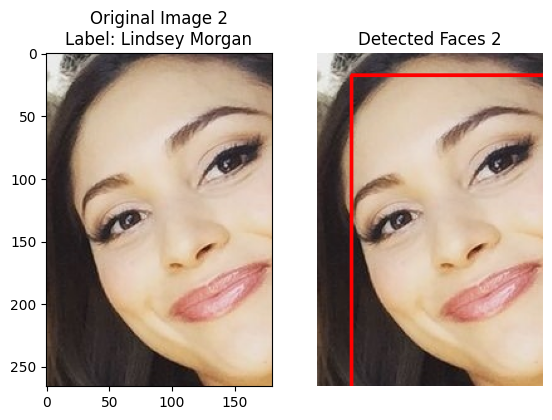

Distance between embeddings: 0.3926


In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances

# Function to process images, detect faces, and calculate embeddings
def process_images(folder_path, face_detector, face_embedder):
    # Randomly pick two files from the selected folder
    files = random.sample(os.listdir(folder_path), 2)

    # Read the images
    image1_path = os.path.join(folder_path, files[0])
    image2_path = os.path.join(folder_path, files[1])

    image1 = cv2.imread(image1_path)
    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    image2 = cv2.imread(image2_path)
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Detect faces using MTCNN
    faces1, _ = face_detector.detect(image1_rgb)
    faces2, _ = face_detector.detect(image2_rgb)

    # Get the label from the folder name
    label = os.path.basename(folder_path)

    # Display original images with rectangles around detected faces
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Original Image 1\nLabel: {label}")

    for i, face in enumerate(faces1):
        x, y, w, h = face
        # Draw a rectangle around the detected face
        cv2.rectangle(image1_rgb, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(image1_rgb))
    plt.title(f"Detected Faces 1")
    plt.axis('off')

    plt.show()

    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Original Image 2\nLabel: {label}")

    for i, face in enumerate(faces2):
        x, y, w, h = face
        # Draw a rectangle around the detected face
        cv2.rectangle(image2_rgb, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(image2_rgb))
    plt.title(f"Detected Faces 2")
    plt.axis('off')

    plt.show()

    # Calculate embeddings for the first image
    embeddings1 = [face_embedder(extract_face(image1_rgb, face).unsqueeze(0)).squeeze().detach().numpy() for face in faces1]

    # Print the embeddings for the first image
    #for i, embeddings in enumerate(embeddings1):
     #   print(f"Embeddings for Detected Face {i + 1} in Image 1:", embeddings)

    # Calculate embeddings for the second image
    embeddings2 = [face_embedder(extract_face(image2_rgb, face).unsqueeze(0)).squeeze().detach().numpy() for face in faces2]

    # Print the embeddings for the second image
   # for i, embeddings in enumerate(embeddings2):
    #    print(f"Embeddings for Detected Face {i + 1} in Image 2:", embeddings)

    # Calculate distance between the two embeddings
    distance = euclidean_distances(embeddings1[0].reshape(1, -1), embeddings2[0].reshape(1, -1))[0][0]

    # Display the distance between the two embeddings
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_directory = '/kaggle/working/train/'

# Randomly pick one folder
selected_folder = random.choice(os.listdir(train_directory))
selected_folder_path = os.path.join(train_directory, selected_folder)

# Initialize MTCNN for face detection
face_detector = MTCNN(keep_all=True)

# Initialize InceptionResnetV1 for face embedding
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

# Process images, detect faces, calculate embeddings, and display results
process_images(selected_folder_path, face_detector, face_embedder)



## PREPROCESSING

We will now apply face detection to all the files in our train folder and save the detected faces as separate images under another folder. Some images may not be easy to detect faces so in those cases, we will skip those images.

In [14]:
import os
import shutil

# Set the directory path
directory_path = '/kaggle/working/train_detected_faces'

# Remove all files and subdirectories in the directory
for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)
    if os.path.isfile(item_path) or os.path.islink(item_path):
        os.unlink(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

print("Contents of train_detected_face cleared.")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/train_detected_faces'

In [15]:
import os
import cv2
import numpy as np

data_directory = '/kaggle/working/train'
output_directory = '/kaggle/working/train_detected_faces'

def detect_faces_and_save(image_paths, output_directory):
    processed_images = []
    images_without_faces = 0

    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Use OpenCV's deep learning-based face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        if len(faces) > 0:
            # Assuming only one face is detected, adjust the dimensions
            x, y, w, h = faces[0]
            face_roi = img[y:y+h, x:x+w]
            resized_face = cv2.resize(face_roi, (224, 224))

            # Get the original folder name
            folder_name = image_path.split('/')[-2]
            # Create the output folder if it doesn't exist
            output_folder = os.path.join(output_directory, folder_name)
            os.makedirs(output_folder, exist_ok=True)

            # Save the detected face with the same folder structure
            output_path = os.path.join(output_folder, f"detected_face_{i}.jpg")
            cv2.imwrite(output_path, resized_face)

            processed_images.append(resized_face)
        else:
            images_without_faces += 1

        if i % 50 == 0:
            print(f"{i}/{len(image_paths)} images processed", end='\r', flush=True)

    print(f"\nImages without faces detected/Total images: {images_without_faces}/{len(image_paths)}")
    return np.array(processed_images)

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Get list of all image paths
all_image_paths = []
for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    if os.path.isdir(folder_path):
        image_paths = [os.path.join(folder_path, image_name) for image_name in os.listdir(folder_path)]
        all_image_paths.extend(image_paths)

X_all_processed = detect_faces_and_save(all_image_paths, output_directory)

print("face detection complete")


Images without faces detected/Total images: 2131/8925
face detection complete


display detected faces - randomly selected

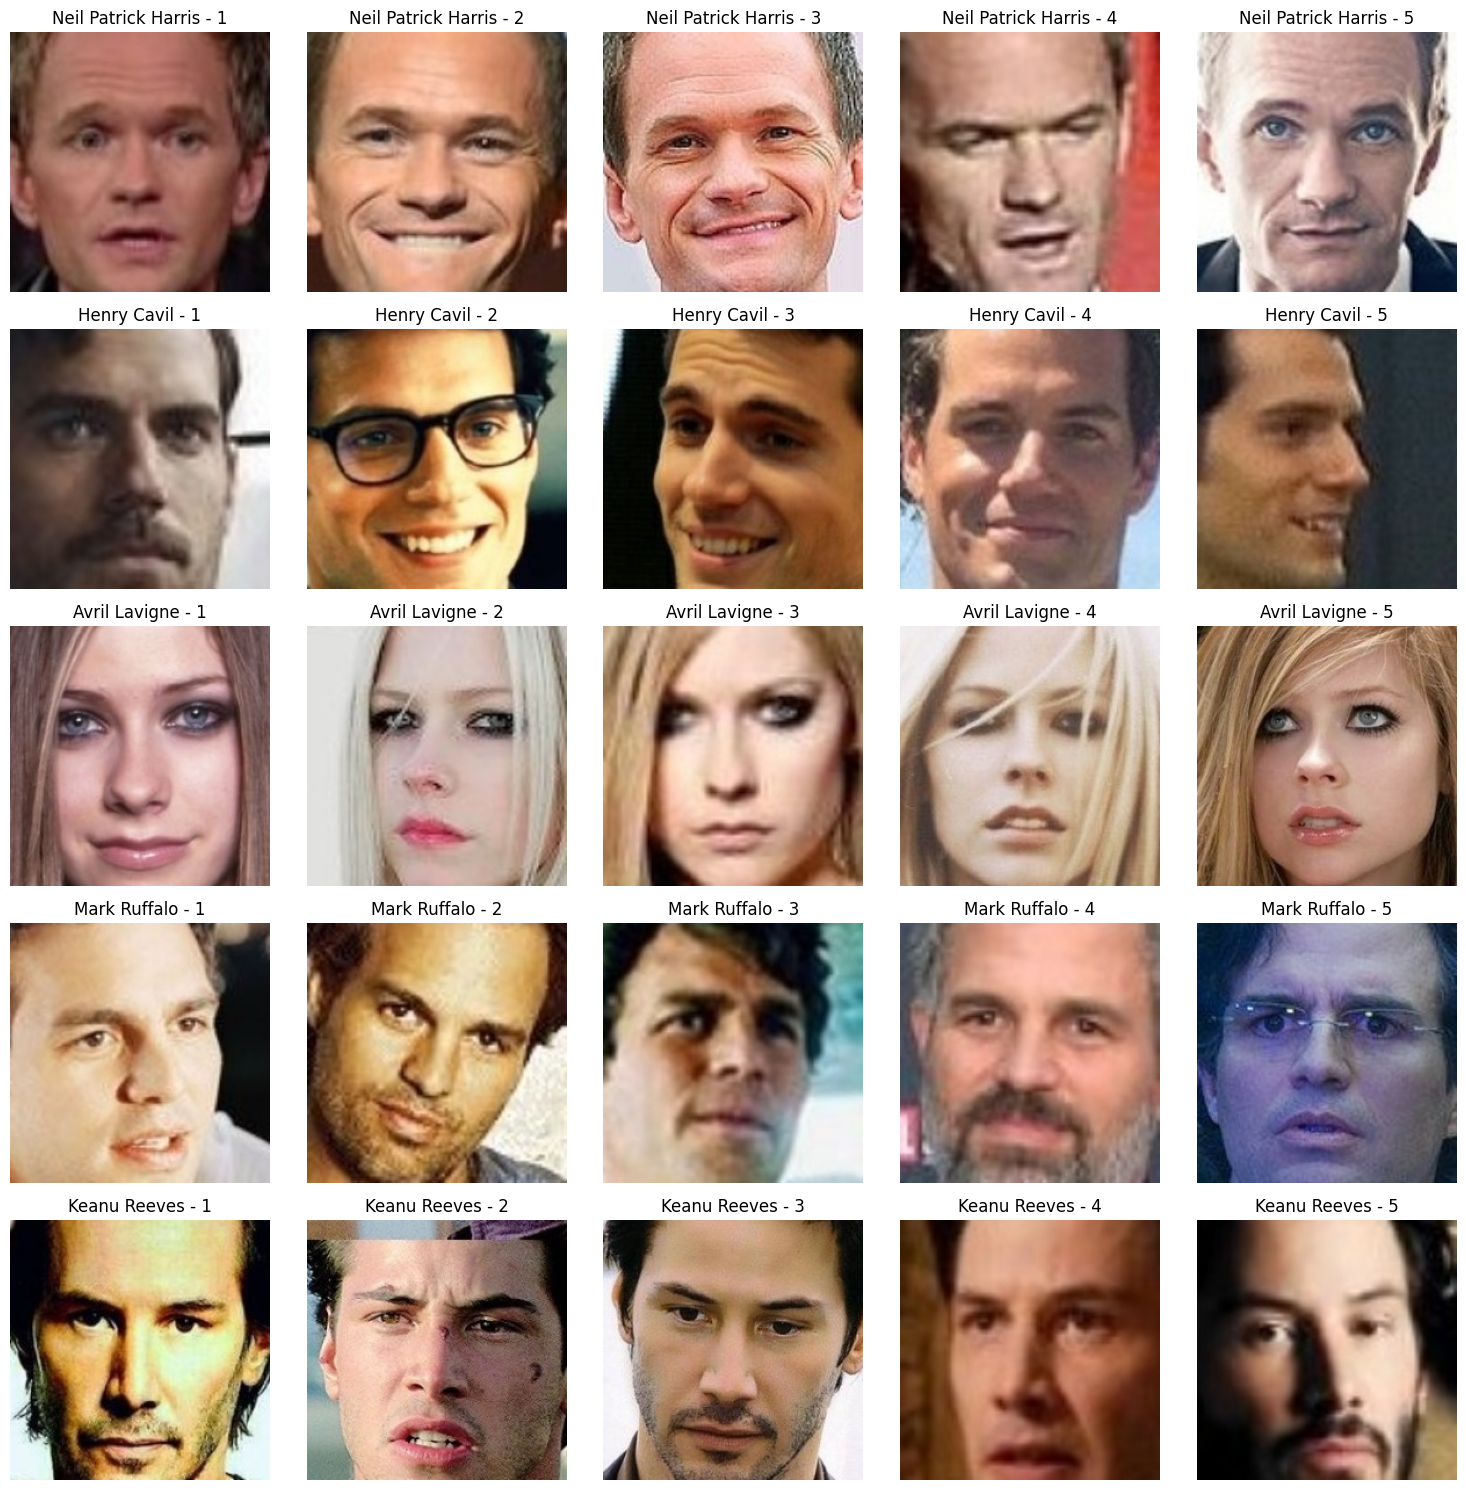

In [16]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Replace this with the path to your detected faces directory
output_directory = '/kaggle/working/train_detected_faces'

# Get a list of subdirectories (folders) in the output directory
folders = [f for f in os.listdir(output_directory) if os.path.isdir(os.path.join(output_directory, f))]

# Randomly pick five folders
selected_folders = np.random.choice(folders, size=5, replace=False)

# Set up the subplot
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for i, folder_name in enumerate(selected_folders):
    folder_path = os.path.join(output_directory, folder_name)
    image_paths = [os.path.join(folder_path, image_name) for image_name in os.listdir(folder_path)[:5]]

    for j, image_path in enumerate(image_paths):
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{folder_name} - {j+1}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


lets look at how many files we have under each folder

In [17]:
import os

output_directory = '/kaggle/working/train_detected_faces'

# Get a list of all folders under the output directory
all_folders = [folder for folder in os.listdir(output_directory) if os.path.isdir(os.path.join(output_directory, folder))]

# Iterate through each folder and print the folder name and file count
for folder in all_folders:
    folder_path = os.path.join(output_directory, folder)
    file_count = len(os.listdir(folder_path))
    print(f"Folder: {folder}, File Count: {file_count}")


Folder: Ursula Corbero, File Count: 35
Folder: Anthony Mackie, File Count: 55
Folder: Rami Malek, File Count: 66
Folder: Nadia Hilker, File Count: 62
Folder: Sarah Wayne Callies, File Count: 69
Folder: Neil Patrick Harris, File Count: 68
Folder: Amanda Crew, File Count: 80
Folder: Avril Lavigne, File Count: 57
Folder: melissa fumero, File Count: 75
Folder: scarlett johansson, File Count: 68
Folder: Katherine Langford, File Count: 77
Folder: Chris Pratt, File Count: 78
Folder: Tom Cruise, File Count: 60
Folder: Tuppence Middleton, File Count: 71
Folder: Rihanna, File Count: 52
Folder: Maisie Williams, File Count: 65
Folder: Krysten Ritter, File Count: 70
Folder: grant gustin, File Count: 68
Folder: Emma Stone, File Count: 62
Folder: Richard Harmon, File Count: 49
Folder: Hugh Jackman, File Count: 68
Folder: Brie Larson, File Count: 63
Folder: Millie Bobby Brown, File Count: 65
Folder: tom ellis, File Count: 55
Folder: margot robbie, File Count: 65
Folder: Jessica Barden, File Count: 67


In [ ]:
!pip install facenet-pytorch

checking embedding distances again between same person vs different people.

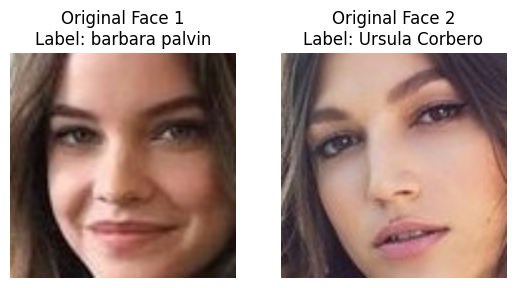

Distance between embeddings: 0.9166


In [18]:

from facenet_pytorch import InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

# Function to process images and calculate embeddings
def process_images(face1_path, face2_path, face_embedder):
    # Read the pre-detected face images
    face1 = cv2.imread(face1_path)
    face1_rgb = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)

    face2 = cv2.imread(face2_path)
    face2_rgb = cv2.cvtColor(face2, cv2.COLOR_BGR2RGB)

    # Get labels from folder names
    label1 = os.path.basename(os.path.dirname(face1_path))
    label2 = os.path.basename(os.path.dirname(face2_path))

    # Display original face images
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(face1_rgb))
    plt.title(f"Original Face 1\nLabel: {label1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(face2_rgb))
    plt.title(f"Original Face 2\nLabel: {label2}")
    plt.axis('off')

    plt.show()

    # Convert NumPy arrays to PyTorch tensors
    face1_tensor = torch.from_numpy(face1_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
    face2_tensor = torch.from_numpy(face2_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0

    # Calculate embeddings for the first face
    embeddings1 = face_embedder(face1_tensor).detach().numpy()

    # Print the embeddings for the first face
    # print("Embeddings for Face 1:", embeddings1)

    # Calculate embeddings for the second face
    embeddings2 = face_embedder(face2_tensor).detach().numpy()

    # Print the embeddings for the second face
    # print("Embeddings for Face 2:", embeddings2)

    # Calculate distance between the two embeddings
    distance = euclidean_distances(embeddings1.reshape(1, -1), embeddings2.reshape(1, -1))[0][0]

    # Display the distance between the two embeddings
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_detected_faces_directory = '/kaggle/working/train_detected_faces/'

# Randomly pick two folders
selected_folders = random.sample(os.listdir(train_detected_faces_directory), 2)

# Randomly pick one file from each selected folder
file1 = random.choice(os.listdir(os.path.join(train_detected_faces_directory, selected_folders[0])))
file2 = random.choice(os.listdir(os.path.join(train_detected_faces_directory, selected_folders[1])))

# Full paths for the selected faces
face1_path = os.path.join(train_detected_faces_directory, selected_folders[0], file1)
face2_path = os.path.join(train_detected_faces_directory, selected_folders[1], file2)

# Initialize InceptionResnetV1 for face embedding
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

# Process face images, calculate embeddings, and display results
process_images(face1_path, face2_path, face_embedder)


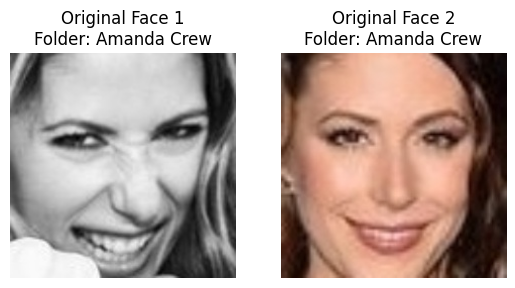

Distance between embeddings: 1.1438


In [19]:
import os
import random
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import torch

# Function to process images and calculate embeddings
def process_images(folder_path, face1_file, face2_file, face_embedder):
    # Read the pre-detected face images
    face1_path = os.path.join(folder_path, face1_file)
    face2_path = os.path.join(folder_path, face2_file)

    face1 = cv2.imread(face1_path)
    face1_rgb = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)

    face2 = cv2.imread(face2_path)
    face2_rgb = cv2.cvtColor(face2, cv2.COLOR_BGR2RGB)

    # Display original face images
    plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(face1_rgb))
    plt.title(f"Original Face 1\nFolder: {os.path.basename(folder_path)}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(face2_rgb))
    plt.title(f"Original Face 2\nFolder: {os.path.basename(folder_path)}")
    plt.axis('off')

    plt.show()

    # Convert NumPy arrays to PyTorch tensors
    face1_tensor = torch.from_numpy(face1_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0
    face2_tensor = torch.from_numpy(face2_rgb.transpose(2, 0, 1)).unsqueeze(0).float() / 255.0

    # Calculate embeddings for the first face
    embeddings1 = face_embedder(face1_tensor).detach().numpy()

    # Print the embeddings for the first face
    # print("Embeddings for Face 1:", embeddings1)

    # Calculate embeddings for the second face
    embeddings2 = face_embedder(face2_tensor).detach().numpy()

    # Print the embeddings for the second face
    # print("Embeddings for Face 2:", embeddings2)

    # Calculate distance between the two embeddings
    distance = euclidean_distances(embeddings1.reshape(1, -1), embeddings2.reshape(1, -1))[0][0]

    # Display the distance between the two embeddings
    print(f"Distance between embeddings: {distance:.4f}")

# Directory paths
train_detected_faces_directory = '/kaggle/working/train_detected_faces/'

# Randomly pick one folder
selected_folder = random.choice(os.listdir(train_detected_faces_directory))
folder_path = os.path.join(train_detected_faces_directory, selected_folder)

# Randomly pick two different files from the selected folder
files = random.sample(os.listdir(folder_path), 2)
face1_file, face2_file = files

# Initialize InceptionResnetV1 for face embedding
face_embedder = InceptionResnetV1(pretrained='vggface2').eval()

# Process face images, calculate embeddings, and display results
process_images(folder_path, face1_file, face2_file, face_embedder)


## EXTRACTING EMBEDDINGS

In [20]:
import shutil
import os

folder_path = '/kaggle/working/extracted_embeddings'

# Check if the folder exists before deleting
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"The folder {folder_path} has been deleted.")
else:
    print(f"The folder {folder_path} does not exist.")


The folder /kaggle/working/extracted_embeddings does not exist.


Extract face embeddings from detected faces folder and save under a different folder - We will also be applying augmentation to increase the sample size to increase accuracy of our detection model. Data augmentation is a technique used in machine learning and computer vision to artificially increase the diversity of a dataset by applying various transformations to the existing data. In the context of face recognition, data augmentation involves creating new training samples by applying different transformations to the original face images. This process helps improve the generalization and robustness of the face recognition model.

Common data augmentation techniques for face recognition include:

Rotation: Rotating the face images by a certain angle (e.g., 90 degrees, 180 degrees) to simulate variations in head pose.

Flip: Mirroring the face images horizontally to account for left-right asymmetry.

Scaling: Resizing the face images to different scales, simulating variations in distance from the camera.

Translation: Shifting the face images horizontally and vertically to simulate variations in position within the frame.

Noise addition: Introducing random noise to the pixel values to make the model more robust to variations in lighting conditions.

Color jitter: Modifying the color of the face images by adjusting brightness, contrast, and saturation.

Elastic distortion: Applying elastic deformation to the face images to simulate facial expressions and deformations.

By augmenting the training data with these variations, the face recognition model becomes more resilient to different conditions it may encounter during testing. Data augmentation is particularly useful when the size of the original dataset is limited, as it helps prevent overfitting and enhances the model's ability to generalize well to unseen faces.

In [22]:

import torch
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Function to extract embeddings from a single folder with data augmentation
def extract_embeddings_from_folder(folder_path, face_embedder, device, output_directory):
    embeddings = {}
    data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    label = os.path.basename(folder_path)  # Get the label from the folder name

    for image_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder_path}"):
        image_path = os.path.join(folder_path, image_name)
        try:
            img = Image.open(image_path)

            # Convert image to tensor
            img_tensor = transforms.ToTensor()(img).unsqueeze(0).float().to(device)

            # Calculate embedding
            embedding = face_embedder(img_tensor).squeeze().detach().cpu().numpy()
            embeddings[image_name] = embedding

            # Save the embedding for the original image
            output_emb_path = os.path.join(output_directory, f"{label}_{os.path.splitext(image_name)[0]}_embedding.npy")
            np.save(output_emb_path, embedding)

            # Apply data augmentation
            augmented_img = data_transform(img)

            # Convert augmented image to tensor
            img_tensor_augmented = augmented_img.unsqueeze(0).float().to(device)

            # Calculate embedding for the augmented image
            embedding_augmented = face_embedder(img_tensor_augmented).squeeze().detach().cpu().numpy()
            embeddings[f"{os.path.splitext(image_name)[0]}_augmented_embedding.npy"] = embedding_augmented

            # Save the embedding for the augmented image
            output_emb_path_augmented = os.path.join(output_directory, f"{label}_{os.path.splitext(image_name)[0]}_augmented_embedding.npy")
            np.save(output_emb_path_augmented, embedding_augmented)

        except Exception as e:
            print(f"Error processing {image_name}: {str(e)}")

    return label, embeddings

# Directory paths
input_directory = '/kaggle/working/train_detected_faces'
output_directory = '/kaggle/working/extracted_embeddings'

# Initialize InceptionResnetV1 for face embedding
device = 'cpu'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
face_embedder = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Loop through each folder in the input directory
for folder_name in os.listdir(input_directory):
    folder_path = os.path.join(input_directory, folder_name)

    # Create subfolder in output_directory for the current label
    label_output_directory = os.path.join(output_directory, folder_name)
    os.makedirs(label_output_directory, exist_ok=True)

    # Extract embeddings from the current folder with data augmentation
    label, embeddings = extract_embeddings_from_folder(folder_path, face_embedder, device, label_output_directory)

print("Embeddings extraction complete.")


Processing /kaggle/working/train_detected_faces/Ursula Corbero: 100%|██████████| 35/35 [00:21<00:00,  1.66it/s]
Processing /kaggle/working/train_detected_faces/Anthony Mackie: 100%|██████████| 55/55 [00:26<00:00,  2.11it/s]
Processing /kaggle/working/train_detected_faces/Rami Malek: 100%|██████████| 66/66 [00:23<00:00,  2.82it/s]
Processing /kaggle/working/train_detected_faces/Nadia Hilker: 100%|██████████| 62/62 [00:21<00:00,  2.85it/s]
Processing /kaggle/working/train_detected_faces/Sarah Wayne Callies: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]
Processing /kaggle/working/train_detected_faces/Neil Patrick Harris: 100%|██████████| 68/68 [00:25<00:00,  2.68it/s]
Processing /kaggle/working/train_detected_faces/Amanda Crew: 100%|██████████| 80/80 [00:27<00:00,  2.87it/s]
Processing /kaggle/working/train_detected_faces/Avril Lavigne: 100%|██████████| 57/57 [00:19<00:00,  2.85it/s]
Processing /kaggle/working/train_detected_faces/melissa fumero: 100%|██████████| 75/75 [00:26<00:00,  2.

Embeddings extraction complete.


Review folders and file counts - We have more files after embedding extraction due to augmentation

In [23]:
import os

# Directory path
output_directory = '/kaggle/working/extracted_embeddings'

# Get folder names and file counts
folders_and_counts = [(folder, len(os.listdir(os.path.join(output_directory, folder)))) for folder in os.listdir(output_directory)]

# Print results
for folder, count in folders_and_counts:
    print(f"Folder: {folder}, Number of Files: {count}")


Folder: Ursula Corbero, Number of Files: 70
Folder: Anthony Mackie, Number of Files: 110
Folder: Rami Malek, Number of Files: 132
Folder: Nadia Hilker, Number of Files: 124
Folder: Sarah Wayne Callies, Number of Files: 138
Folder: Neil Patrick Harris, Number of Files: 136
Folder: Amanda Crew, Number of Files: 160
Folder: Avril Lavigne, Number of Files: 114
Folder: melissa fumero, Number of Files: 150
Folder: scarlett johansson, Number of Files: 136
Folder: Katherine Langford, Number of Files: 154
Folder: Chris Pratt, Number of Files: 156
Folder: Tom Cruise, Number of Files: 120
Folder: Tuppence Middleton, Number of Files: 142
Folder: Rihanna, Number of Files: 104
Folder: Maisie Williams, Number of Files: 130
Folder: Krysten Ritter, Number of Files: 140
Folder: grant gustin, Number of Files: 136
Folder: Emma Stone, Number of Files: 124
Folder: Richard Harmon, Number of Files: 98
Folder: Hugh Jackman, Number of Files: 136
Folder: Brie Larson, Number of Files: 126
Folder: Millie Bobby Bro

We will move 2 images from each folder into a separate test folder to evaluate our face recognition process. We will only move the original embeddings and leave the augmented embeddings in the train folder,

In [24]:
import shutil

folder_path = '/kaggle/working/extracted_embeddingstest'

# Check if the folder exists before deleting
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"The folder {folder_path} has been deleted.")
else:
    print(f"The folder {folder_path} does not exist.")


The folder /kaggle/working/extracted_embeddingstest does not exist.


In [25]:
import shutil

source_folder = "/kaggle/working/extracted_embeddings"
destination_folder = "/kaggle/working/extracted_embeddingstest"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each folder in the source directory
for folder_name in os.listdir(source_folder):
    folder_path = os.path.join(source_folder, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Create the corresponding folder in the destination directory
        destination_folder_path = os.path.join(destination_folder, folder_name)
        os.makedirs(destination_folder_path, exist_ok=True)

        # Get the list of files in the current folder
        files = os.listdir(folder_path)

        # Move the first two files that do not contain "augmented" in their names
        moved_files = 0
        for file_name in files:
            if "augmented" not in file_name:
                source_file_path = os.path.join(folder_path, file_name)
                destination_file_path = os.path.join(destination_folder_path, file_name)

                # Move the file (not copy)
                shutil.move(source_file_path, destination_file_path)
                moved_files += 1

                if moved_files == 2:
                    break  # Break after moving two suitable files

print("Files moved successfully.")


Files moved successfully.


In [26]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=a6c56e2147e36023c0048412eea3ba55d6cba9f48ea3d51484b1a4ac67f716ef
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
!pip install facenet-pytorch numpy scikit-learn


## RECOGNIZING FACES-Using Distances between embeddings


We will use two different approaches - First one will be using the distance between embeddings. Second approach we will train and evaluate a classification model using the embeddings.Idea of the classification model will be for the model to learn from the embedings and be able to classify a newly introduced embedding accurately.

Recognizing faces using distance between embeddings. Our process has few steps:

1) We take the average of all embeddings in the train folder including augmented embeddings for the same label and save those average embeddings first.

2) Then we us ethe files in our test folder to calculate teh distance between average embeddings, looping thru all the labels.

3) Shortest distance between teh embeddings of teh test file vs the average embedding should give us the expected match.

4) Predictions are based on the shortest distance.

5) We will show the results by label first and then we will randomly take 40 images and display the actual and predicted labels.

In [27]:
from sklearn.metrics import pairwise_distances

# Function to calculate average embedding for each label
def calculate_average_embeddings(base_folder):
    average_embeddings = {}

    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            label_embeddings = []
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                # Load embeddings using your preferred method (e.g., np.load())
                embedding = np.load(file_path)
                label_embeddings.append(embedding)

            # Calculate average embedding for the label
            average_embedding = np.mean(label_embeddings, axis=0)
            average_embeddings[label_folder] = average_embedding

    return average_embeddings

# Function to recognize faces based on existing embeddings
def recognize_faces(test_folder, average_embeddings):
    predictions = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)

                # Compare test embedding with averaged embeddings
                distances = {}
                for label, avg_embedding in average_embeddings.items():
                    distance = np.linalg.norm(test_embedding - avg_embedding)
                    distances[label] = distance

                # Predict the label with the minimum distance
                predicted_label = min(distances, key=distances.get)
                predictions.append((file_name, label_folder, predicted_label))

    return predictions


# folder paths
base_folder = '/kaggle/working/extracted_embeddings'
test_folder = '/kaggle/working/extracted_embeddingstest'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Recognize faces in the test folder
predictions = recognize_faces(test_folder, average_embeddings)

# Print the predictions
for file_name, actual_label, predicted_label in predictions:
    print(f"{file_name}: Actual Label - {actual_label}, Predicted Label - {predicted_label}")


Ursula Corbero_detected_face_84_embedding.npy: Actual Label - Ursula Corbero, Predicted Label - Ursula Corbero
Ursula Corbero_detected_face_47_embedding.npy: Actual Label - Ursula Corbero, Predicted Label - Ursula Corbero
Anthony Mackie_detected_face_120_embedding.npy: Actual Label - Anthony Mackie, Predicted Label - Anthony Mackie
Anthony Mackie_detected_face_117_embedding.npy: Actual Label - Anthony Mackie, Predicted Label - Anthony Mackie
Rami Malek_detected_face_199_embedding.npy: Actual Label - Rami Malek, Predicted Label - Rami Malek
Rami Malek_detected_face_249_embedding.npy: Actual Label - Rami Malek, Predicted Label - Rami Malek
Nadia Hilker_detected_face_287_embedding.npy: Actual Label - Nadia Hilker, Predicted Label - Nadia Hilker
Nadia Hilker_detected_face_257_embedding.npy: Actual Label - Nadia Hilker, Predicted Label - Nadia Hilker
Sarah Wayne Callies_detected_face_357_embedding.npy: Actual Label - Sarah Wayne Callies, Predicted Label - margot robbie
Sarah Wayne Callies_d

Results displayed using the detected faces.Images randomlly selected based on test embeddings.

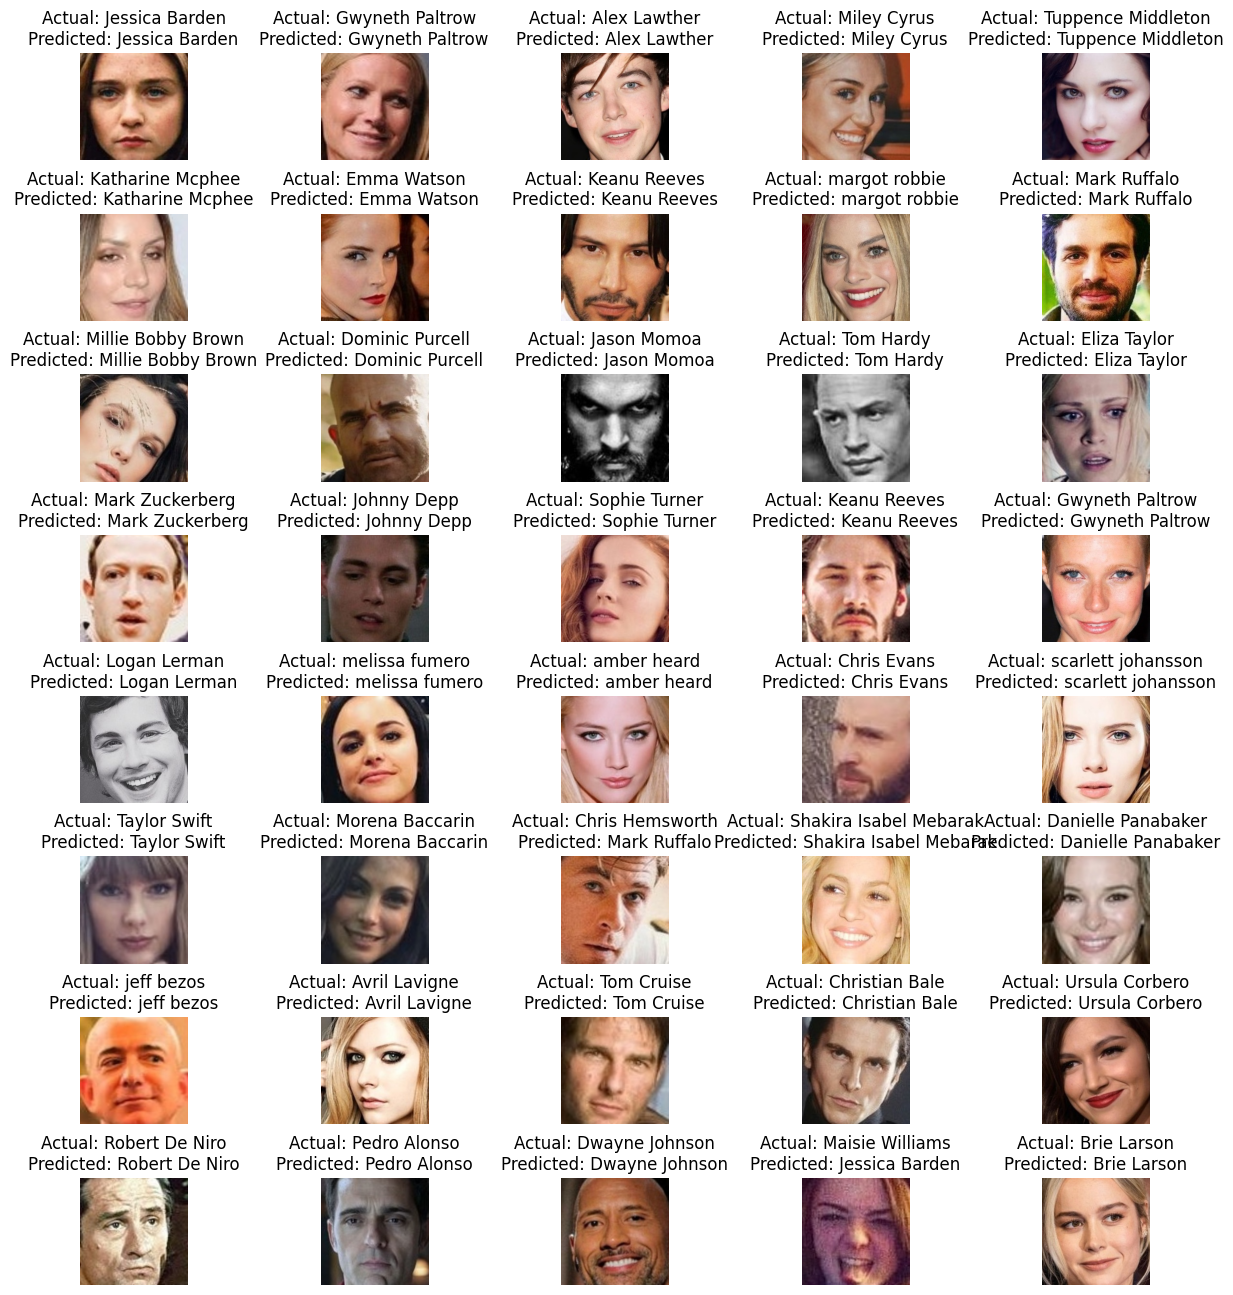

In [28]:

from sklearn.metrics import pairwise_distances
from PIL import Image

# Function to calculate average embedding for each label
def calculate_average_embeddings(base_folder):
    average_embeddings = {}

    for label_folder in os.listdir(base_folder):
        label_path = os.path.join(base_folder, label_folder)
        if os.path.isdir(label_path):
            label_embeddings = []
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                # Load embeddings using your preferred method (e.g., np.load())
                embedding = np.load(file_path)
                label_embeddings.append(embedding)

            # Calculate average embedding for the label
            average_embedding = np.mean(label_embeddings, axis=0)
            average_embeddings[label_folder] = average_embedding

    return average_embeddings

# Function to recognize faces based on existing embeddings
def recognize_faces(test_folder, average_embeddings):
    predictions = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)

                # Compare test embedding with averaged embeddings
                distances = {}
                for label, avg_embedding in average_embeddings.items():
                    distance = np.linalg.norm(test_embedding - avg_embedding)
                    distances[label] = distance

                # Predict the label with the minimum distance
                predicted_label = min(distances, key=distances.get)
                predictions.append((file_name, label_folder, predicted_label))

    return predictions

import random

# Function to display images with actual and predicted labels
def display_random_images(predictions, image_folder, num_images=40):
    selected_predictions = random.sample(predictions, min(num_images, len(predictions)))

    # Calculate the number of rows and columns based on the desired number of images
    num_rows = (num_images + 4) // 5  # Ensure at least 1 row
    num_cols = min(5, num_images)  # Maximum of 5 columns

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2 * num_rows))
    fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing

    for i, (file_name, actual_label, predicted_label) in enumerate(selected_predictions):
        # Extract identifier from the file name
        identifier_start = file_name.find("_detected_face_") + len("_detected_face_")
        identifier_end = file_name.find("_", identifier_start)
        if identifier_end == -1:
            identifier = file_name[identifier_start:]
        else:
            identifier = file_name[identifier_start:identifier_end]

        # Construct the file path for the corresponding image
        image_name = f"detected_face_{identifier}.jpg"
        image_path = os.path.join(image_folder, actual_label, image_name)

        # Display the actual image along with labels
        try:
            image = Image.open(image_path)
            axes[i // 5, i % 5].imshow(image)
            axes[i // 5, i % 5].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
            axes[i // 5, i % 5].axis('off')

        except FileNotFoundError:
            print(f"Image not found for {identifier}. Skipping to the next one.")

    plt.show()

display_random_images(predictions, '/kaggle/working/train_detected_faces', num_images=40)

# folder paths
base_folder = '/kaggle/working/extracted_embeddings'
test_folder = '/kaggle/working/extracted_embeddingstest'
image_folder = '/kaggle/working/train_detected_faces'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Recognize faces in the test folder
predictions = recognize_faces(test_folder, average_embeddings)

# Display 10 images with actual and predicted labels
#display_images(predictions, image_folder, num_images=10)


Below takes two random embedding files and shows the distance calculations against all the average embeddings for all the labels. You can observe the shortest distance is used to find a match.

In [29]:
def load_test_embeddings(test_folder):
    test_embeddings = []

    for label_folder in os.listdir(test_folder):
        label_path = os.path.join(test_folder, label_folder)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Load test embedding from the saved numpy file
                test_embedding = np.load(file_path)
                test_embeddings.append((file_name, label_folder, test_embedding))

    return test_embeddings


# folder paths
base_folder = '/kaggle/working/extracted_embeddings'
test_folder = '/kaggle/working/extracted_embeddingstest'

# Load existing average embeddings
average_embeddings = calculate_average_embeddings(base_folder)

# Load test embeddings
test_embeddings = load_test_embeddings(test_folder)

# Randomly pick two test embeddings
random_test_embeddings = random.sample(test_embeddings, 2)

# Print the randomly picked test embeddings
#for file_name, label, test_embedding in random_test_embeddings:
 #   print(f"Randomly Picked Test Embedding ({label}): {test_embedding}")

# Calculate and print distances between the random test embeddings and all average embeddings
for file_name, label, test_embedding in random_test_embeddings:
    print(f"\nDistances for {file_name} ({label}) against Average Embeddings:")
    for avg_label, avg_embedding in average_embeddings.items():
        distance = np.linalg.norm(test_embedding - avg_embedding)
        print(f"  Distance to {avg_label}: {distance}")



Distances for Leonardo DiCaprio_detected_face_7456_embedding.npy (Leonardo DiCaprio) against Average Embeddings:
  Distance to Ursula Corbero: 1.1031131744384766
  Distance to Anthony Mackie: 1.1327238082885742
  Distance to Rami Malek: 0.8678029775619507
  Distance to Nadia Hilker: 1.1698582172393799
  Distance to Sarah Wayne Callies: 1.2121421098709106
  Distance to Neil Patrick Harris: 1.0284621715545654
  Distance to Amanda Crew: 1.29562246799469
  Distance to Avril Lavigne: 1.3294332027435303
  Distance to melissa fumero: 1.207436203956604
  Distance to scarlett johansson: 1.275795817375183
  Distance to Katherine Langford: 1.299242377281189
  Distance to Chris Pratt: 0.9074296355247498
  Distance to Tom Cruise: 1.004252314567566
  Distance to Tuppence Middleton: 1.150825023651123
  Distance to Rihanna: 1.1106806993484497
  Distance to Maisie Williams: 1.190736174583435
  Distance to Krysten Ritter: 1.3830913305282593
  Distance to grant gustin: 0.8387846946716309
  Distance to E

## RECOGNIZING FACES - Classification model - Multilayered Neural Network

This is an implementation of a neural network for classification using PyTorch deep learning library. Model trains on the embeddings and learns from each embedding for each label and then is evaluated on the test embeddings.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Disable CUDA
torch.cuda.is_available = lambda : False

# Set the device to CPU
device = torch.device("cpu")

# Load embeddings and labels
data_dir = "/kaggle/working/extracted_embeddings"
embeddings = []
labels = []

for label_folder in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_folder)
    if os.path.isdir(label_path):
        label = label_folder  # Assuming the folder names are labels
        embeddings_per_label = []

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if file_name.endswith(".npy"):
                embedding = np.load(file_path)
                embeddings_per_label.append(embedding)
                labels.append(label)

        embeddings.append(embeddings_per_label)

# Flatten the embeddings list
embeddings = [item for sublist in embeddings for item in sublist]

# Convert data to PyTorch tensors
X = torch.tensor(embeddings, dtype=torch.float32)
labels = np.array(labels)

# Use LabelEncoder to encode string labels into integers
label_encoder = LabelEncoder()
y = torch.tensor(label_encoder.fit_transform(labels), dtype=torch.long)

# Split the data into 80% training, 10% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define an updated model with more layers
class UpdatedModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(UpdatedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
num_classes = len(set(y_train))
model = UpdatedModel(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_inputs = X_val.to(device)
        val_labels = y_val.to(device)

        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Evaluation on the test data
model.eval()
with torch.no_grad():
    test_inputs = X_test.to(device)
    test_labels = y_test.to(device)

    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_labels)

# Decode the predicted labels using inverse_transform
predicted_labels = label_encoder.inverse_transform(torch.argmax(test_outputs, dim=1).cpu().numpy())

# Decode the true labels using inverse_transform
true_labels = label_encoder.inverse_transform(y_test.cpu().numpy())

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

#print("Confusion Matrix:")
#print(confusion_matrix(true_labels, predicted_labels))


<ipython-input-30-ccba59b3fe29>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X = torch.tensor(embeddings, dtype=torch.float32)


Epoch 1/20, Train Loss: 2.9878, Validation Loss: 2.9533
Epoch 2/20, Train Loss: 1.8861, Validation Loss: 1.5546
Epoch 3/20, Train Loss: 1.4008, Validation Loss: 1.0417
Epoch 4/20, Train Loss: 1.1997, Validation Loss: 0.7951
Epoch 5/20, Train Loss: 1.0071, Validation Loss: 0.6615
Epoch 6/20, Train Loss: 0.7758, Validation Loss: 0.5901
Epoch 7/20, Train Loss: 0.6304, Validation Loss: 0.5398
Epoch 8/20, Train Loss: 0.5059, Validation Loss: 0.5030
Epoch 9/20, Train Loss: 0.4108, Validation Loss: 0.4808
Epoch 10/20, Train Loss: 0.3401, Validation Loss: 0.4641
Epoch 11/20, Train Loss: 0.2914, Validation Loss: 0.4481
Epoch 12/20, Train Loss: 0.2479, Validation Loss: 0.4380
Epoch 13/20, Train Loss: 0.2110, Validation Loss: 0.4224
Epoch 14/20, Train Loss: 0.1736, Validation Loss: 0.4143
Epoch 15/20, Train Loss: 0.1366, Validation Loss: 0.4105
Epoch 16/20, Train Loss: 0.1146, Validation Loss: 0.4044
Epoch 17/20, Train Loss: 0.0897, Validation Loss: 0.4127
Epoch 18/20, Train Loss: 0.0852, Validat

## CONCLUSION

We achieved almost 90% accuracy with a simple neural network set up with no fine tuning and only running with 20 epochs. Using more of the data and applying more augmentation can still improve detection rates. Recogniton using the distances seems to be achieving better results.